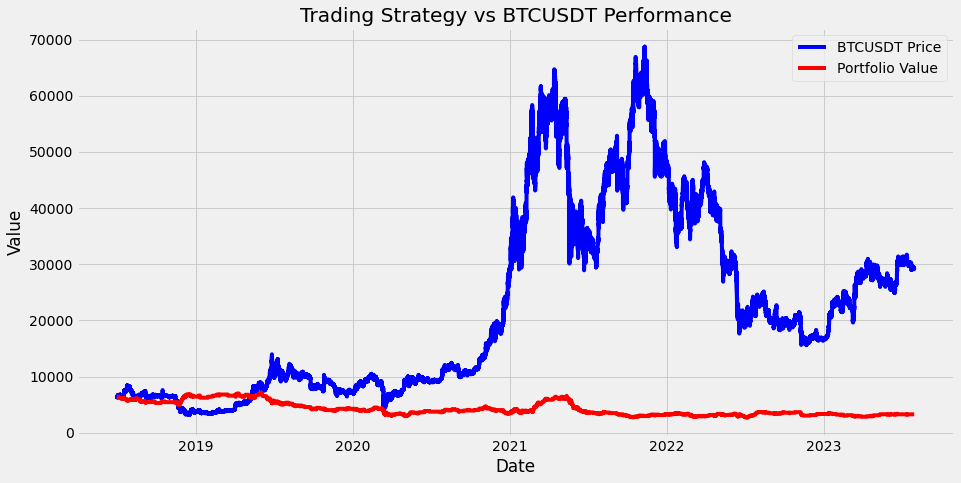

Total number of trades: 689
Success rate: 49.056603773584904%


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#Loading dataset
df = pd.read_csv("BTCUSDT_stock_data_test_5mins_5year.csv")

#Initializing variables
n_bollinger = 20
n_rsi = 14
capital = df.loc[0, 'Close']
df['Portfolio_Value'] = capital
position = 0
entry_price = 0
num_trades = 0
num_successful_trades = 0
prev_rsi = 0  #To keep track of the previous RSI value

#Calculate rolling mean and rolling standard deviation for Bollinger Bands
df['Rolling_Mean'] = df['Close'].rolling(window=n_bollinger).mean()
df['Rolling_Std'] = df['Close'].rolling(window=n_bollinger).std()
df['Upper_Band'] = df['Rolling_Mean'] + 2 * df['Rolling_Std']
df['Lower_Band'] = df['Rolling_Mean'] - 2 * df['Rolling_Std']

#Calculating RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=n_rsi).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=n_rsi).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))


#Backtesting loop
for i in range(max(n_bollinger, n_rsi), len(df)):
    close = df.loc[i, 'Close']
    upper_band = df.loc[i, 'Upper_Band']
    lower_band = df.loc[i, 'Lower_Band']
    rsi = df.loc[i, 'RSI']
    risk_per_trade = 0.03 * capital  #3% risk of current capital

    if position == 0:
        if close < lower_band and rsi < 30 and prev_rsi >= 30:
            entry_price = close
            position = 1
            stop_loss = entry_price * 0.95  #5% stop loss
            target = entry_price + (entry_price-stop_loss) 
            num_trades += 1
        elif close > upper_band and rsi > 70 and prev_rsi <= 70:
            entry_price = close
            position = -1
            stop_loss = entry_price * 1.05  #5% stop loss
            target = entry_price - (stop_loss-entry_price)  
            num_trades += 1

    elif position == 1:
        if close >= target:
            capital += risk_per_trade
            position = 0
            num_successful_trades += 1
        elif close <= stop_loss:
            capital -= risk_per_trade
            position = 0


    elif position == -1:
        if close <= target:
            capital += risk_per_trade
            position = 0
            num_successful_trades += 1
        elif close >= stop_loss:
            capital -= risk_per_trade
            position = 0

    df.loc[i, 'Portfolio_Value'] = capital

    prev_rsi = rsi  #Retaining the current RSI value for the next iteration

#Plotting
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df['Open Time']), df['Close'], label='BTCUSDT Price',color='b')
plt.plot(pd.to_datetime(df['Open Time']), df['Portfolio_Value'], label='Portfolio Value',color='r')
plt.legend()
plt.title('Trading Strategy vs BTCUSDT Performance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

#Calculate success rate
if num_trades > 0:
    success_rate = (num_successful_trades / num_trades) * 100
else:
    success_rate = 0

print(f'Total number of trades: {num_trades}')
print(f'Success rate: {success_rate}%')



In [28]:
def calculate_drawdowns(return_series):
    running_max = return_series.cummax()
    running_max[running_max < return_series.iloc[0]] = return_series.iloc[0]
    drawdown = (return_series / running_max) - 1
    return drawdown

def calculate_max_drawdown(drawdown_series):
    return drawdown_series.min() * 100  # returns max drawdown in percentage


In [29]:
#Calculate the returns for BTCUSDT
df['BTC_Returns'] = df['Close'].pct_change()
df['BTC_Returns'].fillna(0, inplace=True)

#Calculate cumulative returns
df['BTC_Cumulative_Returns'] = (1 + df['BTC_Returns']).cumprod()


In [30]:
#Calculate and plot drawdowns for Portfolio and BTCUSDT
portfolio_drawdown = calculate_drawdowns(df['Portfolio_Value'])
btcusdt_drawdown = calculate_drawdowns(df['BTC_Cumulative_Returns'] * df.loc[0, 'Close'])

#Calculate max drawdowns
max_portfolio_drawdown = calculate_max_drawdown(portfolio_drawdown)
max_btcusdt_drawdown = calculate_max_drawdown(btcusdt_drawdown)


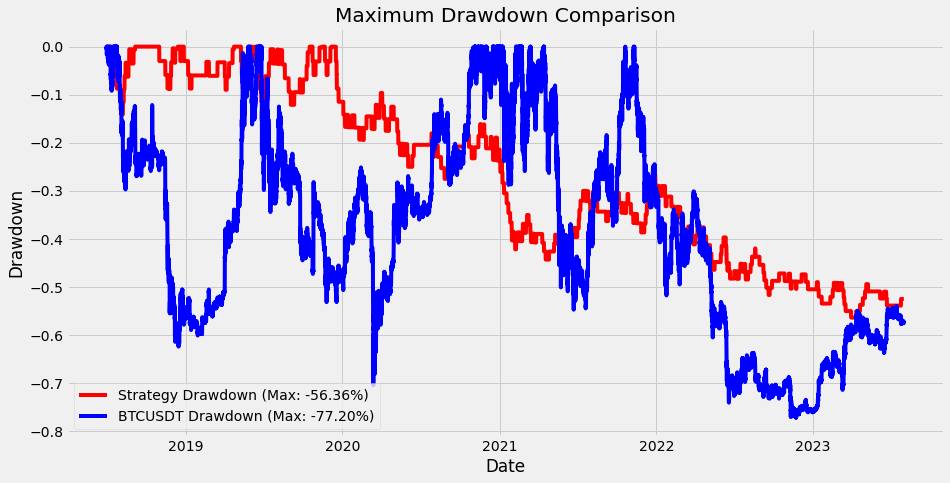

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df['Open Time']), portfolio_drawdown, label=f'Strategy Drawdown (Max: {max_portfolio_drawdown:.2f}%)', color='r')
plt.plot(pd.to_datetime(df['Open Time']), btcusdt_drawdown, label=f'BTCUSDT Drawdown (Max: {max_btcusdt_drawdown:.2f}%)', color='b')
plt.title('Maximum Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


In [32]:
#Calculate the final values
final_portfolio_value = df.loc[len(df) - 1, 'Portfolio_Value']
final_btc_price = df.loc[len(df) - 1, 'Close']

#Calculate the initial values
initial_portfolio_value = df.loc[0, 'Portfolio_Value']
initial_btc_price = df.loc[0, 'Close']

#Calculate the total percentage return for the trading strategy
portfolio_return_percentage = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

#Calculate the total percentage return for BTCUSDT buy-and-hold strategy
btc_return_percentage = ((final_btc_price - initial_btc_price) / initial_btc_price) * 100

print(f'Total percentage return of the trading strategy: {portfolio_return_percentage:.2f}%')
print(f'Total percentage return of the BTCUSDT buy-and-hold strategy: {btc_return_percentage:.2f}%')


Total percentage return of the trading strategy: -24.24%
Total percentage return of the BTCUSDT buy-and-hold strategy: 362.35%
